<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installed the required library and downloaded the model

In [31]:
!pip install spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Imported the required modules

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import numpy as np
import PIL
import warnings
import spacy
warnings.filterwarnings("ignore")
import networkx as nx

# Defined the functions to be used for data cleaning

In [33]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

# Defined and called the data cleaning function

In [34]:
def clean_df(df):
  df = pd.read_excel(df)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  df = df.drop('Notes', axis=1)
  df = df.drop('Notes2', axis=1)
  df = df.drop('About Adam Smith', axis=1)
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Rep
Date,,
1995-05-23,"As everybody knows, a little earlier this year...",Peter Anthony DeFazio\nDemocratic Party
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",Raymond Eugene “Gene” Green\n Democratic Party
1996-05-23,"When wages fall, buying power drops, and all t...",Ronald Paul Klink\nDemocratic Party
1999-10-13,These arguments are no truer today than they w...,Paul David Wellstone\nDemocratic Party
1999-10-27,Go right back to Alexander Hamilton in the ear...,Ernest Frederick “Fritz” Hollings\nDemocratic ...


# Defined and called the function cleaning the representatives column

In [35]:
def clean_rep_data(df):
  rep = []
  for index, row in df.iterrows():
    if row['Rep'].strip() != 'PRESIDENT BUSH':
      rep.append(row['Rep'].strip().splitlines())
    else:
      rep.append(['President Bush', 'Republican Party'])
  rep_with_numbers = list(enumerate(rep))
  rep[106] = ['Alvin H. Perlmutter', 'Other']
  rep[99] = ['Not known', 'Other']
  rep[100] = ['Not known', 'Other']
  rep[83] = ['William Wilson', 'Other']
  rep[70] = ['Daniel Benjamin Maffei\xa0', 'Democratic Party']
  rep[66] =  ['Bill Etheridge', 'Other']
  rep[55] = ['Brad Sherman', 'Democratic Party']
  rep[56] = ['Brad Sherman', 'Democratic Party']
  rep[38] =  ['Tim Walz', 'Other']
  rep[82] = ['Keith Maurice Ellison', 'Other']
  rep[93] = ['n/a', 'n/a']
  df['Representative'] = [x[0] for x in rep]
  party = [x[1] for x in rep]
  for i in range(len(party)):
    if 'Democratic' in party[i]:
      party[i] = 'Democrats'
    elif 'Republican' in party[i]:
      party[i] = 'Republicans'
    else:
      pass
  df['Party'] = party
  df = df.drop(df[df['Party'] == 'n/a'].index, axis=0)
  df = df.drop('Rep', axis=1)
  return df
df = clean_rep_data(df)
display(df.head())

,Extract,Representative,Party
Date,,,
1995-05-23,"As everybody knows, a little earlier this year...",Peter Anthony DeFazio,Democrats
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",Raymond Eugene “Gene” Green,Democrats
1996-05-23,"When wages fall, buying power drops, and all t...",Ronald Paul Klink,Democrats
1999-10-13,These arguments are no truer today than they w...,Paul David Wellstone,Democrats
1999-10-27,Go right back to Alexander Hamilton in the ear...,Ernest Frederick “Fritz” Hollings,Democrats


# Defined and called the function saving a histogram as a file

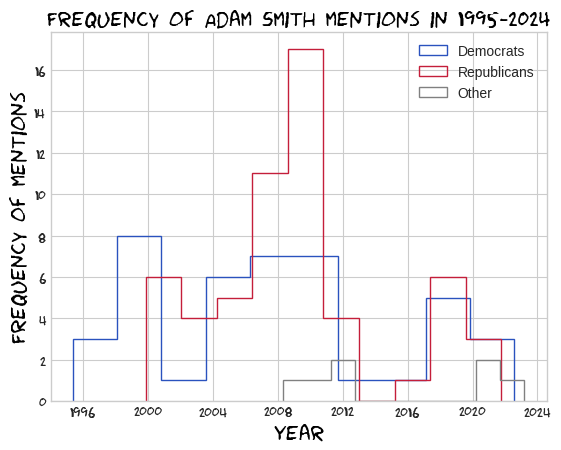

<Figure size 700x700 with 0 Axes>

In [36]:
def create_histogram(df):
  fig, ax = plt.subplots()
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df[df['Party']=='Democrats'].index, color='#2a52be', histtype='step')
  plt.hist(df[df['Party']=='Republicans'].index, color='#C41E3A', histtype='step')
  plt.hist(df[df['Party']=='Other'].index, color='grey', histtype='step')
  plt.legend(labels = ['Democrats', 'Republicans', 'Other'], bbox_to_anchor=[1.0,1.0])
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in 1995-2024', fontdict = font)
  plt.figure(figsize=[7,7])
  fig.savefig('histogram.png', dpi=1000)
create_histogram(df)

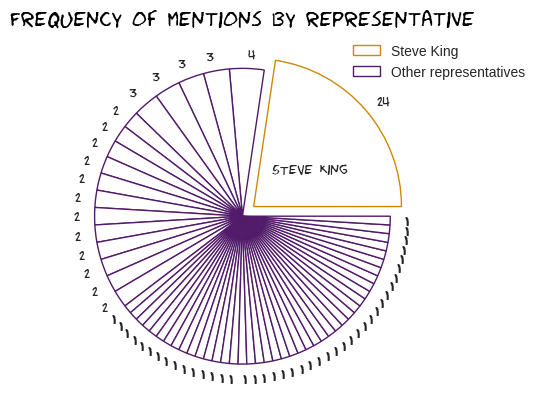

<Figure size 700x700 with 0 Axes>

In [37]:
def create_rep_countplot(df):
  fig, ax = plt.subplots()
  f = df.groupby('Representative')['Representative'].count().sort_values(ascending=False)
  font = {'family':'fantasy','color':'black','size':15}
  explode = [0 for i in f.index]
  explode[0] = 0.1
  wedges, texts = plt.pie(f, labels=f, explode=explode, wedgeprops = {'color': 'white', 'edgecolor': '#511B6A', 'linewidth':1}, textprops = {'fontname': 'fantasy'})
  wedges[0].set_edgecolor('#D1870A')
  plt.annotate('Steve King', xy=(0, 0.5), xytext=(0.2, 0.3), fontname='fantasy')
  plt.yticks(fontname="fantasy", fontsize=6)
  plt.xticks(fontname="fantasy")
  plt.legend(['Steve King', 'Other representatives'], bbox_to_anchor=(0.7,0.8,0.6,0.2))
  legend = ax.get_legend()
  legend.legendHandles[0].set_edgecolor('#D1870A')
  plt.title('Frequency of mentions by representative', fontdict = font)
  plt.figure(figsize=[7,7])
  fig.savefig('pie_chart.png', dpi=1000)
create_rep_countplot(df)

In [38]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.tail())

,Extract,Representative,Party,Extract length
Date,,,,
2021-10-06,We are a nation that exploded forth to be the ...,Cory Anthony Booker,Democrats,273
2021-10-07,That was 98 percent of the world. Fast-forward...,Rand Paul,Republicans,593
2022-07-19,"You go back, way back, to the godfather of cap...",Ms. KLOBUCHAR,Democrats,298
2022-07-26,"adam Smith—the godfather of capitalism, the gu...",Ms. KLOBUCHAR,Democrats,367
2023-03-09,Adam Smith’s Money World,Alvin H. Perlmutter,Other,24


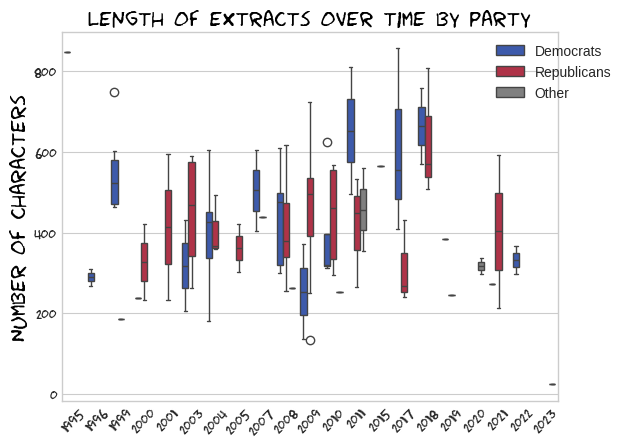

<Figure size 700x700 with 0 Axes>

In [39]:
def create_boxplots_of_text_length(df):
  fig, ax = plt.subplots()
  g = sns.boxplot(ax=ax, x=df.index.year, y=df['Extract length'], hue=df['Party'], palette=['#2a52be', '#C41E3A', 'grey', 'black'])
  plt.legend(bbox_to_anchor = [0.85, 1.0])
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy", rotation=45)
  plt.xlabel('Date', fontdict = font)
  plt.yticks(fontname="fantasy")
  plt.ylabel('Number of characters', fontdict = font)
  plt.xlabel("")
  plt.title('Length of extracts over time by party', fontdict = font)
  plt.figure(figsize=[7,7])
  fig.savefig('boxplots.png', dpi=1000)
create_boxplots_of_text_length(df)


In [40]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

,Extract,Representative,Party,Extract length,Polarity,Subjectivity
Date,,,,,,
1995-05-23,"As everybody knows, a little earlier this year...",Peter Anthony DeFazio,Democrats,847,0.034375,0.404167
1996-05-23,"Mr. GENE GREEN of Texas. Mr. Speaker, to my co...",Raymond Eugene “Gene” Green,Democrats,269,0.166667,0.400000
1996-05-23,"When wages fall, buying power drops, and all t...",Ronald Paul Klink,Democrats,310,0.383333,0.391667
1999-10-13,These arguments are no truer today than they w...,Paul David Wellstone,Democrats,748,0.055417,0.514167
1999-10-27,Go right back to Alexander Hamilton in the ear...,Ernest Frederick “Fritz” Hollings,Democrats,464,0.183036,0.222619


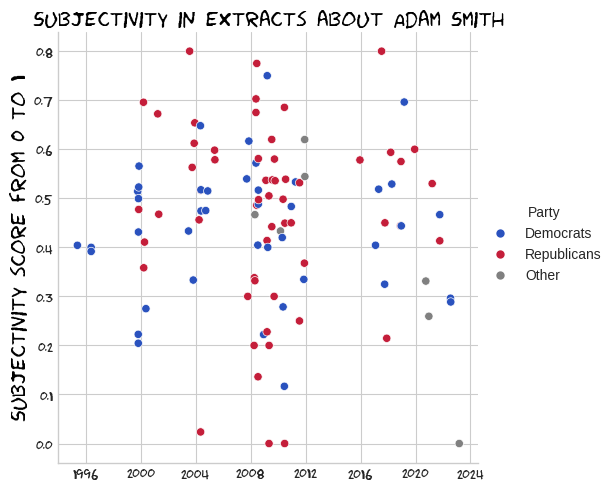

<Figure size 1200x1200 with 0 Axes>

In [41]:
def plot_subjectivity_score(df):
  g = sns.relplot(x=df.index, y=df['Subjectivity'], hue=df['Party'], palette=['#2a52be', '#C41E3A', 'grey', 'black'])
  fig = g.fig
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.title('Subjectivity in extracts about Adam Smith', fontdict = font)
  plt.xlabel('')
  plt.ylabel('Subjectivity score from 0 to 1', fontdict = font)
  plt.figure(figsize=[12,12])
  fig.savefig('subjectivity.png', dpi=1000)
plot_subjectivity_score(df_sentiments)

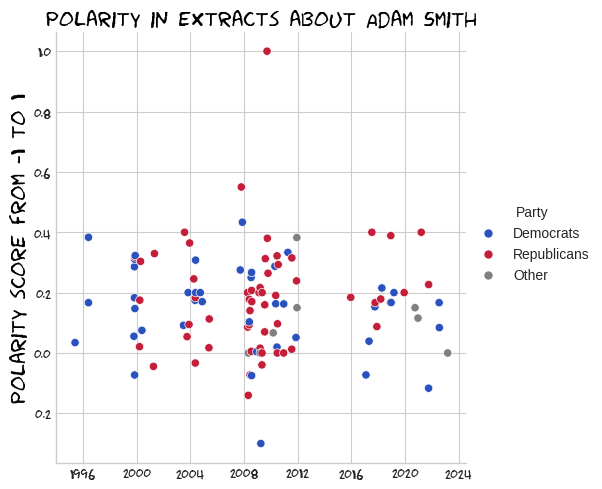

<Figure size 700x700 with 0 Axes>

In [30]:
def plot_polarity_score(df):
  g = sns.relplot(x=df.index, y=df['Polarity'], hue=df['Party'], palette=['#2a52be', '#C41E3A', 'grey', 'black'])
  fig = g.fig
  font = {'family':'fantasy','color':'black','size':15}
  plt.xticks(fontname="fantasy")
  plt.yticks(fontname="fantasy")
  plt.ylabel('Polarity score from -1 to 1', fontdict = font)
  plt.xlabel('')
  plt.title('Polarity in extracts about Adam Smith', fontdict = font)
  plt.figure(figsize=[7,7])
  fig.savefig('polarity.png', dpi=1000)
plot_polarity_score(df_sentiments)

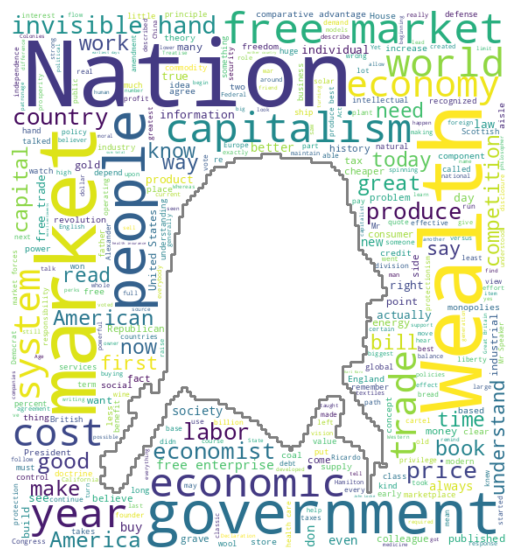

In [42]:
def word_cloud(df):
  stopwords = set(STOPWORDS)
  stopwords.update(['s', 't', 'Adam', 'Smith', 'will', 'let', 'go', 'one', 'take', 'u', 'said', 'wrote', 'going', 'think', 'back', 'never', 'us', 'well'])
  image = PIL.Image.open("/content/mask.png")
  image = image.convert('L')
  image = PIL.ImageOps.invert(image)
  image.convert('1')
  mask = np.array(image)
  plt.figure(figsize=[7,7])
  text = ""
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, mask=mask, contour_width=2, contour_color='grey').generate(text)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.savefig('wordcloud.png', dpi=1000)
word_cloud(df)

In [43]:
def create_entity_list(df):
  nlp = spacy.load('en_core_web_md')
  texts = []
  for index, row in df.iterrows():
    texts.append(nlp(row['Extract']))
  documents = [nlp(text) for text in texts]
  entity_lists = []
  for doc in documents:
    entity_list = []
    for ent in doc.ents:
      if ent.label_ == 'PERSON':
        entity_list.append(ent)
    entity_lists.append(entity_list)
  shortened_entity_list = []
  for i in entity_lists:
    if len(i) == 1 and str(i[0]).lower() == 'adam smith':
      pass
    elif len(i) == 2 and str(i[0]).lower() == 'adam smith' and str(i[1]).lower() == 'adam smith':
      pass
    elif len(i) == 0:
      pass
    else:
      shortened_entity_list.append(i)
  return shortened_entity_list
print(create_entity_list(df))

[[Ronald Reagan, Adam Smith, Adam Smith], [GENE GREEN, Speaker, Adam Smith], [Adam Smith, Adam Smith, Jim Braun], [Alexander Hamilton, David Ricardo, Adam Smith], [Alexander Hamilton, David Ricardo, Adam Smith, Hamilton], [Adam Smith, Schumer], [Adam Smith, littleknown, Keynes], [Adam Smith, Thomas Paine, John Stewart Mill, Milton Friedman], [John Locke, Adam Smith, Wilberforce], [Adam Smith, Joseph Schumpeter], [Ricardo, Adam Smith], [REID, Adam Smith], [Ricardo, Adam Smith], [Adam Smith, Komisar], [Adam Smith, Karl Marx, Karl Marx, Adam Smith], [Adam Smith, Smith], [Adam Smith’s], [Jack Kemp, Adam Smith], [Adam Smith, Obama], [Adam Smith, Adam Smith, Adam Smith], [Patronage, Adam Smith], [Obama, the Adam Smith], [John Locke, Adam Smith, William Blackstone], [Alexander Tytler, Adam Smith, Alexander Tytler], [Adam Smith, Karl Marx, Adam Smith], [Adam Smithian], [Adam Smith, Adam Smith, Adam Smith, Adam Smith], [John Locke, Adam Smith], [Adam Smith, John Maynard], [HUNTER, Adam Smith, A

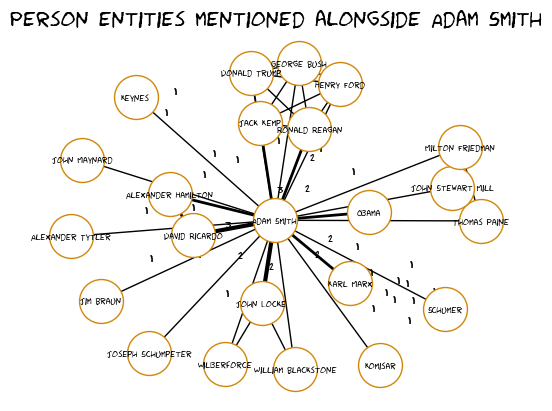

In [44]:
def create_network_graph():
  person_entities = {'Ronald Reagan': 2, 'Jim Braun': 1, 'Alexander Hamilton': 2, 'David Ricardo': 3, 'Schumer': 1,  'Keynes': 1, \
  'Thomas Paine': 1, 'John Stewart Mill': 1, 'Milton Friedman': 1, 'John Locke': 3, 'Wilberforce': 1, 'Joseph Schumpeter': 1, 'Komisar': 1, \
  'Karl Marx': 2, 'Jack Kemp': 2, 'Obama': 2, 'William Blackstone': 1, 'Alexander Tytler': 1, 'John Maynard': 1, 'George Bush': 1, \
  'Henry Ford': 1, 'Donald Trump': 1}
  fig, ax = plt.subplots()
  G = nx.Graph()
  nodes = list(person_entities.keys())
  nodes.append('Adam Smith')
  G.add_nodes_from(nodes)
  [G.add_edge('Adam Smith', i, weight=person_entities[i]) for i in person_entities]
  G.add_edge('Alexander Hamilton', 'David Ricardo', weight=2)
  G.add_edge('Thomas Paine', 'John Stewart Mill', weight=1)
  G.add_edge('John Stewart Mill', 'Milton Friedman', weight=1)
  G.add_edge('Thomas Paine', 'Milton Friedman', weight=1)
  G.add_edge('John Locke', 'Wilberforce', weight=1)
  G.add_edge('John Locke', 'William Blackstone', weight=1)
  G.add_edge('Ronald Reagan', 'George Bush', weight=1)
  G.add_edge('Ronald Reagan', 'Jack Kemp', weight=1)
  G.add_edge('Ronald Reagan', 'Henry Ford', weight=1)
  G.add_edge('Ronald Reagan', 'Donald Trump', weight=1)
  G.add_edge('George Bush', 'Jack Kemp', weight=1)
  G.add_edge('George Bush', 'Henry Ford', weight=1)
  G.add_edge('George Bush', 'Donald Trump', weight=1)
  G.add_edge('Jack Kemp', 'Henry Ford', weight=1)
  G.add_edge('Jack Kemp', 'Donald Trump', weight=1)
  G.add_edge('Henry Ford', 'Donald Trump', weight=1)
  edge_width = [G[u][v]['weight'] for u, v in G.edges()]
  edge_labels = dict(zip(G.edges(), [str(G[u][v]['weight']) for u, v in G.edges()]))
  pos = nx.spring_layout(G)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, rotate=False, font_family='fantasy')
  for node in nodes:
    G.nodes[node]['label'] = node
  nx.draw(G, width=edge_width, with_labels=True, node_size=1000, font_size=6, font_family='fantasy', node_color='white', edgecolors='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.title('Person entities mentioned alongside Adam Smith',  fontdict=font)
  fig.savefig('network.png', dpi=1000)
create_network_graph()